# ? Sujet ?

# Importations.

In [1]:
import os
import codecs 
import sys
import re
import string
from bs4 import BeautifulSoup

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.tag import pos_tag

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd # DataFrame, ...
import numpy as np # array, ...

In [4]:
# Visualistion
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

## Classifier
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Variables globales.

In [6]:
DEBUG = False
TEST = 2000
MAX_FEATURES = 1500
OUT_CSV = "./out/csv/"

# Fonctions.

## Outils.

### Lecture des fichiers et création des *datasets*.

In [7]:
def create_dataset(directory):
	data = []

	# Files counter.
	file_count = 0

	# Loop for files.
	for filename in os.listdir(directory):
		
		file = os.path.join(directory, filename)
		if os.path.isfile(file):
			with codecs.open(file, "r", encoding="utf-8") as f:
				
				# File name parsing to get id and rating.
				split_extension = filename.split(".")
				split_id_rating = split_extension[0].split("_")
				id_str = split_id_rating[0]
				rating_str = split_id_rating[1]
				rating = -1

				try:
					rating = int(rating_str)
				except ValueError:
					sys.exit("Error casting rating to int")

				review = f.read()
				sentiment = 1 if directory.__contains__("pos") else 0
				data.append([review, rating, sentiment])
				file_count += 1
				
	print("file_count : {}".format(file_count))
	return pd.DataFrame(data, columns=["review", "rating", "sentiment"])

### *Preprocessing*.

In [8]:
def preprocess(df):
	reviews = []
	sentiments = []

	for index, row in df.iterrows():
		review = row["review"]
		sentiment = row["sentiment"]
		
		review = BeautifulSoup(review, "html.parser").text

		verbs = ["VBP", "VBN", "VBG", "VBD", "VB"]
		proper_noun = ["NNS", "NNP", "NNPS"]
		review = ' '.join(
			[lemmatizer.lemmatize(word, pos = "v") if tag in verbs 
			else lemmatizer.lemmatize(word) 
			for word, tag in pos_tag(word_tokenize(review)) 
			if tag not in proper_noun])
		
		review = review.translate(str.maketrans('', '', string.punctuation))
		
		review = ' '.join([word.lower() for word in review.split()])

		review = ' '.join([word for word in review.split() if word not in ["movie", "film", "story"]])
		
		review = ' '.join([word for word in review.split() if not word.isnumeric()])
		
		review = ' '.join([word for word in review.split() if word not in stop_words])

		review = ' '.join([word for word in review.split() if re.match("[a-zA-Z]", word)])

		reviews.append(review)
		sentiments.append(sentiment)

	data = {"review": reviews, "sentiment": sentiments}
	df_prepro = pd.DataFrame(data)
	return df_prepro

### Suppression des mots communs entre les *positive reviews* et *negative reviews*.

In [106]:
def remove_common_word(df):
	df_positive_words = df[df["sentiment"] == 1]
	df_negative_words = df[df["sentiment"] == 0]

	positive_words = df_positive_words["review"].values
	negative_words = df_negative_words["review"].values

	positive_fd = set(nltk.FreqDist(positive_words))
	negative_fd = set(nltk.FreqDist(negative_words))

	common_set = positive_fd.intersection(negative_fd)

	old_reviews = df["review"].values
	new_reviews = []
	words_removed = 0
	for review in old_reviews:
		new_review = []
		for word in review.split():
			if word not in common_set:
				new_review.append(word)
			else:
				words_removed += 1
		new_reviews.append(" ".join(word for word in new_review))


	print("{} words removed !".format(words_removed))
	data = {"review": new_reviews, "sentiment": df["sentiment"].values}
	new_df = pd.DataFrame(data)
	return new_df

## Entrainement.

In [10]:
def entrainement(classifiers, X_train, X_test, y_train, y_test):
	liste_predictions = []
	
	for nom, classifier in classifiers.items():
		print(nom)

		print("fitting...")
		pipeline_classifier = Pipeline([
			('vectorize', CountVectorizer(max_features=MAX_FEATURES)),
			('tfidf', TfidfTransformer()),
			('classifier', classifier),
		])
		pipeline_classifier = pipeline_classifier.fit(X_train, y_train)

		print("predicting labels...")
		y_pred_test = pipeline_classifier.predict(X_test)

		liste_predictions.append((nom, pipeline_classifier, y_pred_test))
		print("")
	
	return liste_predictions

## Evaluation.

### Rapport de classification.

In [11]:
def my_classification_report(df, class_name, pred, y_test):
	print(classification_report(y_true=y_test, y_pred=pred))

### Matrice de confusion.

In [12]:
def my_confusion_matrix(model_name, df, class_name, pred, y_test, figsize):
    labels = np.unique(df[class_name].values)
    conf_matrix = confusion_matrix(y_test, pred, labels=labels)
    df_conf_matrix = pd.DataFrame(conf_matrix, columns=labels)
    df_conf_matrix["index"] = labels
    df_conf_matrix = df_conf_matrix.set_index("index")

    plt.figure(figsize=figsize)
    sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Matrice de confusion pour {model_name}")
    plt.show()

### Courbe d'apprentissage.

In [13]:
def my_learning_curve(model_name, model, x_train, y_train, figsize):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model, X=x_train, y=y_train, 
        train_sizes=np.linspace(0.1, 1.0, 4),
        n_jobs=10, verbose=0, random_state=42)

    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    #
    # Plot the learning curve
    #
    plt.figure(figsize=figsize)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(model_name + ' Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

### *Roc curve*.

In [14]:
def plot_roc_curve(model_fit, X_test, y_test, figsize): 
	probs = model_fit.predict_proba(X_test)  
	probs = probs[:, 1]
	fper, tper, thresholds = roc_curve(y_test, probs) 

	plt.figure(figsize=figsize)
	plt.plot(fper, tper, color='orange', label='ROC')
	plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')

	plt.title('Receiver Operating Characteristic (ROC) Curve')

	plt.legend()
	plt.show()

### Evaluation global.

In [15]:
def evaluation(liste_prediction, df, class_name, X_train, X_test, y_train, y_test):
	for nom, model_fit, y_pred_test in liste_prediction:
		print(nom)
		my_classification_report(df, class_name, y_pred_test, y_test)

		figsize = (4,3)
		my_confusion_matrix(nom, df, class_name, y_pred_test, y_test, figsize)

		# my_learning_curve(nom, model_fit, X_train, y_train, figsize)

		# plot_roc_curve(model_fit, X_test, y_test, figsize)

# Lecture des fichiers et création des *datasets*.

## *Trainset*.

### *Positive reviews*

In [16]:
df_train_pos = create_dataset("./data/train/pos/")
df_train_pos

file_count : 12500


,review,rating,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1
...,...,...,...
12495,"Seeing as the vote average was pretty low, and...",9,1
12496,"The plot had some wretched, unbelievable twist...",8,1
12497,I am amazed at how this movie(and most others ...,10,1
12498,A Christmas Together actually came before my t...,8,1


### *Negative reviews*

In [17]:
df_train_neg = create_dataset("./data/train/neg/")
df_train_neg

file_count : 12500


,review,rating,sentiment
0,Story of a man who has unnatural feelings for ...,3,0
1,Airport '77 starts as a brand new luxury 747 p...,4,0
2,This film lacked something I couldn't put my f...,4,0
3,"Sorry everyone,,, I know this is supposed to b...",1,0
4,When I was little my parents took me along to ...,1,0
...,...,...,...
12495,"Towards the end of the movie, I felt it was to...",4,0
12496,This is the kind of movie that my enemies cont...,3,0
12497,I saw 'Descent' last night at the Stockholm Fi...,3,0
12498,Some films that you pick up for a pound turn o...,1,0


### Création du *trainset*.

In [18]:
df_train = pd.concat([df_train_pos, df_train_neg], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_train

,review,rating,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1
...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",4,0
24996,This is the kind of movie that my enemies cont...,3,0
24997,I saw 'Descent' last night at the Stockholm Fi...,3,0
24998,Some films that you pick up for a pound turn o...,1,0


### Ecriture dans un fichier.

In [19]:
df_train.to_csv(f"{OUT_CSV}df_train.csv", index=False)

## *Testset*.

### *Positive reviews*

In [20]:
df_test_pos = create_dataset("./data/test/pos/")
df_test_pos

file_count : 12500


,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
12495,I was extraordinarily impressed by this film. ...,8,1
12496,"Although I'm not a golf fan, I attended a snea...",10,1
12497,"From the start of ""The Edge Of Love"", the view...",8,1
12498,"This movie, with all its complexity and subtle...",10,1


### *Negative reviews*

In [21]:
df_test_neg = create_dataset("./data/test/neg/")
df_train_neg

file_count : 12500


,review,rating,sentiment
0,Story of a man who has unnatural feelings for ...,3,0
1,Airport '77 starts as a brand new luxury 747 p...,4,0
2,This film lacked something I couldn't put my f...,4,0
3,"Sorry everyone,,, I know this is supposed to b...",1,0
4,When I was little my parents took me along to ...,1,0
...,...,...,...
12495,"Towards the end of the movie, I felt it was to...",4,0
12496,This is the kind of movie that my enemies cont...,3,0
12497,I saw 'Descent' last night at the Stockholm Fi...,3,0
12498,Some films that you pick up for a pound turn o...,1,0


### Création du *testset*.

In [22]:
df_test = pd.concat([df_test_pos, df_test_neg], axis=0)
df_test.reset_index(drop=True, inplace=True)
df_test

,review,rating,sentiment
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
24995,I occasionally let my kids watch this garbage ...,1,0
24996,When all we have anymore is pretty much realit...,1,0
24997,The basic genre is a thriller intercut with an...,3,0
24998,Four things intrigued me as to this film - fir...,3,0


### Ecriture dans un fichier.

In [23]:
df_test.to_csv(f"{OUT_CSV}df_test.csv", index=False)

# *Preprocessing*.

## *Trainset*.

In [24]:
if DEBUG:
	df_train = df_train.sample(TEST)

In [25]:
df_train_prepro = preprocess(df_train)
df_train_prepro

d:\Programmation\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,sentiment
0,cartoon comedy run time school life teaching p...,1
1,state ha issue never plan help street consider...,1
2,brilliant overacting dramatic hobo lady ever s...,1
3,easily underrated inn cannon sure flaw doe giv...,1
4,typical much le slapstick actually plot follow...,1
...,...,...
24995,towards end felt technical felt like classroom...,0
24996,kind content watch time bloody true watch make...,0
24997,saw last night one huge disappointment disappo...,0
24998,pick pound turn rather good release obscure it...,0


### Ecriture dans un fichier.

In [26]:
df_train_prepro.to_csv(f"{OUT_CSV}df_train_prepro.csv", index=False)

## *Testset*.

In [27]:
if DEBUG:
	df_test = df_test.sample(TEST)

In [28]:
df_test_prepro = preprocess(df_test)
df_test_prepro

d:\Programmation\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,sentiment
0,go saw last night coax mine admit reluctant se...,1
1,actor turn director follows promising debut fa...,1
2,recreational golfer knowledge sport history pl...,1
3,saw sneak preview delightful cinematography un...,1
4,ha take true golf open make much extraordinary...,1
...,...,...
24995,occasionally let watch garbage understand path...,0
24996,anymore pretty much reality tv make whatever r...,0
24997,basic genre thriller intercut uncomfortable me...,0
24998,four intrigue firstly star fame always pleasur...,0


### Ecriture dans un fichier.

In [29]:
df_test_prepro.to_csv(f"{OUT_CSV}df_test_prepro.csv", index=False)

## Suppression des mots communs.

In [96]:
df_train_prepro2 = pd.read_csv(f"{OUT_CSV}df_train_prepro.csv")
df_test_prepro2 = pd.read_csv(f"{OUT_CSV}df_test_prepro.csv")

### *Trainset*.

In [107]:
df_train_prepro2 = remove_common_word(df_train_prepro2)

0 words removed !


In [108]:
df_train_prepro2.to_csv(f"{OUT_CSV}df_train_prepro2.csv", index=False)

### *Testset*.

In [109]:
df_test_prepro2 = remove_common_word(df_test_prepro2)

0 words removed !


In [110]:
df_test_prepro2.to_csv(f"{OUT_CSV}df_test_prepro2.csv", index=False)

# Classification.

In [111]:
df_train_classify = pd.read_csv(f"{OUT_CSV}df_train_prepro2.csv")
df_test_classify = pd.read_csv(f"{OUT_CSV}df_test_prepro2.csv")

In [118]:
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

## Découpage en X et y.

In [119]:
X_train, y_train = df_train_classify["review"].values, df_train_classify["sentiment"].values
X_test, y_test = df_test_classify["review"].values, df_test_classify["sentiment"].values

## Entrainement.

In [120]:
liste_predictions = entrainement(classifiers, X_train, X_test, y_test, y_test)

MultinomialNB
fitting...
predicting labels...

BernoulliNB
fitting...
predicting labels...

ComplementNB
fitting...
predicting labels...

KNeighborsClassifier
fitting...
predicting labels...


## Evaluation.

MultinomialNB
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     12500
           1       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



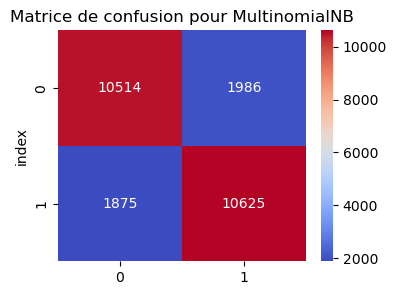

In [ ]:
evaluation(liste_predictions, df_test_classify, "sentiment", X_train, X_test, y_train, y_test)